In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [7]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [8]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(
        train_data,
        batch_size = 100,
        shuffle = True,
        num_workers = 1
    ),

    'test': DataLoader(
        test_data,
        batch_size = 100,
        shuffle = True,
        num_workers = 1
    ),
}

In [9]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x20488743860>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x20488480680>}

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim = 1)

In [11]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.01)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders['train'].dataset),
                100. * batch_idx / len(loaders['train']), loss.item()
            ))

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    
    test_loss /= len(loaders['test'].dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loaders['test'].dataset),
        100. * correct / len(loaders['test'].dataset)
    ))

In [12]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300189
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.768859
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.159903
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.781020
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.902612
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.567061
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.466488
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.761625
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.655259
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.792342
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.748995
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.564055
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.356248
Train Epoch: 1 [26000/60000 (43%)]	Loss: 0.411990
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.791834
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.510581
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.454678
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.413835
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.335015
Train Epoch: 1 [38000/60000 (63%)]	Loss: 0.439597
Train Epoch

Prediction: 0.0000


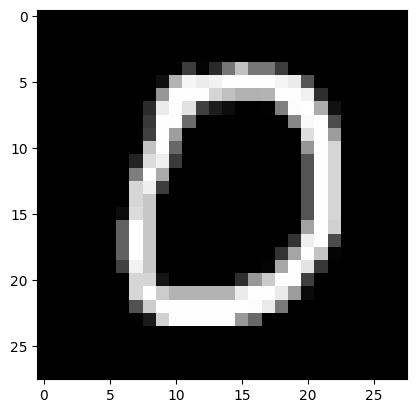

In [34]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[10]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim = 1, keepdim = True).item()

print('Prediction: {:.4f}'.format(prediction))

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap = 'gray')

plt.show()
